# Setup

In [ ]:
!pip install neurodsp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
#computing spectrum
from neurodsp.spectral import compute_spectrum

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import sawtooth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Signal simulater

## burst generator

In [ ]:
def classify_burst(value: float):
    """
    Classify a given float value into one of the predefined categories.

    Parameters:
        value (float): The input value to classify.

    Returns:
        str: The classification category as a string.
    """
    if value < 0.0:
        raise ValueError("Value must be non-negative.")

    if 0.0 <= value < 4.0:
        return 0      # "noise"
    elif 4.0 <= value < 8.0:
        return 1      # "theta"
    elif 8.0 <= value < 13.0:
        return 2      # "alpha"
    elif 13.0 <= value < 30.0:
        return 3      #"beta"
    elif 30.0 <= value < 110.0:
        return 4      #"gamma"
    else:
        raise ValueError("Value does not fall within known classification categories.")


burst_name = classify_burst(15.0)
print(type(burst_name), burst_name)

<class 'int'> 3


In [ ]:
def get_duration(duration_param):
    """
    Determines a duration value.

    If duration_param is a scalar (int or float), returns it.
    If it is a two-element list/tuple/array, returns a random value drawn uniformly
    between the two values.
    """
    if isinstance(duration_param, (list, tuple, np.ndarray)) and len(duration_param) == 2:
        return np.random.uniform(duration_param[0], duration_param[1])
    elif np.isscalar(duration_param):
        return duration_param
    else:
        raise ValueError("Duration parameter must be a scalar or a two-element list/tuple/array.")


def generate_simple_bursts(time_vec, fs, freqs, burst_cycles, noise_duration,
                           burst_type, amp_scale=0.1):
    """
    Simulates a signal over a given time vector where each segment is chosen to be either noise or a burst.
    Burst segments are modulated such that each cycle of the oscillation is scaled by its own random amplitude.

    State 0 is reserved for noise (its segments are left as zeros so that noise can be added later),
    while states > 0 produce burst segments.

    In this version the burst duration is specified as the number of cycles.
    For each burst, the actual duration in seconds is computed as:

         duration = (number of cycles) / (burst frequency)

    This implementation forces an integer number of cycles by computing the number of samples per cycle.

    Burst and noise durations can be provided as fixed values (scalar) or as a two-element
    sequence [min, max] to sample a random value uniformly (for noise).

    Parameters:
        time_vec (array-like): The time points for the simulation.
        fs (float): The sampling frequency.
        freqs (scalar or array-like): Frequency (in Hz) for burst segments.
            - If a scalar, all burst states use the same frequency.
            - If array-like, its length must equal the number of burst states.
        burst_cycles (scalar or two-element sequence): Number of cycles per burst.
            If a two-element sequence, a random number of cycles is drawn uniformly from that range.
        noise_duration (scalar or two-element sequence): Duration (in seconds) for each noise segment.
            If a two-element sequence, a random duration is drawn uniformly from that interval.
        burst_type (str): "sine" or "sawtooth" determines the waveform for burst segments.
        amp_scale (float): Standard deviation for the normal distribution used to generate the random amplitude per cycle.

    Returns:
        signal (ndarray): The simulated signal (same length as time_vec). Burst segments contain oscillations;
                          noise segments are left as zeros.
        state_ts (ndarray): A one-hot encoded state matrix of shape (len(time_vec), num_states).
                           Each row is a one-hot vector indicating the active state.
    """
    # Convert freqs to a numpy array for convenience.
    freqs_array = np.array(freqs)
    freqs_size = freqs_array.size

    if freqs_size == 1:
        use_scalar_freq = True
    else:
        use_scalar_freq = False

    # Define the number of states.
    # State 0 is noise, and states 1, 2, ... are burst segments.
    num_states = freqs_size + 1
    initial_state_probs = np.ones(num_states) / num_states  # Uniform probabilities.

    signal = np.zeros(len(time_vec))
    state_indicator = np.zeros(len(time_vec))

    t = 0.0  # Global time pointer (in seconds)
    last_state = None

    while t < time_vec[-1]:
        # Choose a state that is not the same as the last state.
        if last_state is None:
            current_state = np.random.choice(np.arange(num_states), p=initial_state_probs)
        else:
            valid_states = np.delete(np.arange(num_states), last_state)
            valid_probs = np.delete(initial_state_probs, last_state)
            valid_probs = valid_probs / valid_probs.sum()
            current_state = np.random.choice(valid_states, p=valid_probs)

        last_state = current_state
        start_idx = int(t * fs)

        if current_state == 0:
            # --- Noise Segment ---
            curr_noise_duration = get_duration(noise_duration)
            end_idx = start_idx + int(np.round(curr_noise_duration * fs))
            if end_idx > len(time_vec):
                end_idx = len(time_vec)
            state_indicator[start_idx:end_idx] = 0  # Noise state.
            t += curr_noise_duration
        else:
            # --- Burst Segment ---
            if use_scalar_freq:
                freq_burst = freqs_array.item()
            else:
                # For burst states, use current_state - 1 since state 0 is noise.
                freq_burst = freqs_array[current_state - 1]

            # Determine the number of cycles (force integer cycles)
            if isinstance(burst_cycles, (list, tuple, np.ndarray)) and len(burst_cycles) == 2:
                num_cycles = int(round(np.random.uniform(burst_cycles[0], burst_cycles[1])))
            elif np.isscalar(burst_cycles):
                num_cycles = int(round(burst_cycles))
            else:
                raise ValueError("burst_cycles must be a scalar or a two-element sequence.")

            # Compute the number of samples per cycle and then the total samples.
            samples_per_cycle = int(round(fs / freq_burst))
            total_samples = samples_per_cycle * num_cycles
            aligned_time = np.arange(total_samples) / fs

            # Generate amplitude modulation: one amplitude per cycle, repeated for each sample in that cycle.
            cycle_amplitudes = np.abs(np.random.normal(1, amp_scale, size=num_cycles))
            amplitude_array = np.repeat(cycle_amplitudes, samples_per_cycle)

            # Generate the burst waveform.
            if burst_type == "sine":
                burst_signal = amplitude_array * np.sin(2 * np.pi * freq_burst * aligned_time)
            elif burst_type == "sawtooth":
                burst_signal = amplitude_array * sawtooth(2 * np.pi * freq_burst * aligned_time, width=1)
            else:
                raise ValueError("Unsupported burst_type. Choose 'sine' or 'sawtooth'.")

            end_idx = start_idx + total_samples
            if end_idx > len(time_vec):
                # Truncate burst if it exceeds the signal length.
                burst_signal = burst_signal[:len(time_vec) - start_idx]
                end_idx = len(time_vec)

            signal[start_idx:end_idx] = burst_signal
            state_indicator[start_idx:end_idx] = current_state

            # Advance time exactly by the burst duration.
            curr_burst_duration = total_samples / fs
            t += curr_burst_duration

    burst_class = classify_burst(freqs)

    state_indicator = state_indicator * burst_class # Changes the burst values to corresponding class

    return np.array(signal), np.array(state_indicator).astype(int)


## noise generator

In [ ]:
def generate_colored_noise(N, beta, seed=None):
    """
    Generate colored noise with a 1/f^beta power spectrum.

    Parameters:
        beta (float): Exponent for the 1/f^beta distribution.
                      Use beta=0 for white noise, beta=1 for pink noise, beta=2 for brown noise.
        N (int): Number of samples in the noise signal.
        seed (int, optional): Seed for the random number generator.

    Returns:
        np.ndarray: The generated noise signal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate white noise in the time domain.
    white_noise = np.random.randn(N)

    # Transform to frequency domain using the real FFT.
    f = np.fft.rfft(white_noise)

    # Create frequency array; np.fft.rfftfreq returns frequencies for the rFFT.
    frequencies = np.fft.rfftfreq(N)

    # Avoid division by zero at DC: set it to a small non-zero value.
    if len(frequencies) > 1:
        frequencies[0] = frequencies[1]
    else:
        frequencies[0] = 1.0

    # Apply the frequency filter: scale each frequency component by 1/(f^(beta/2)).
    scaling_factors = 1 / (frequencies ** (beta / 2.0))
    f_filtered = f * scaling_factors

    # Transform back to the time domain.
    colored_noise = np.fft.irfft(f_filtered, n=N)

    # Normalize the signal to have unit standard deviation.
    colored_noise /= np.std(colored_noise)

    return np.array(colored_noise)

In [ ]:
def generate_noise(N, beta=1, white_noise_weight=0.3, colored_noise_weight=0.7):
    """
    Generates a noise signal as a weighted combination of white noise and colored noise.
    """
    white_noise = np.random.randn(N)
    colored_noise = generate_colored_noise(N, beta, seed=None)

    noise = white_noise_weight * white_noise + colored_noise_weight * colored_noise
    return noise

In [ ]:
def add_noise(signal, noise, snr_db):
    """
    Add noise to a signal to achieve a desired SNR (in dB).

    Parameters:
        signal (ndarray): Clean signal.
        noise (ndarray): Noise signal.
        snr_db (float): Desired SNR in decibels.

    Returns:
        ndarray: The noisy signal.
    """
    # Calculate the power of the signal.
    signal_power = np.mean(signal**2)
    # Convert SNR from dB to linear.
    snr_linear = 10**(snr_db / 10)
    # Compute the desired noise power.
    desired_noise_power = signal_power / snr_linear
    # Compute current noise power.
    current_noise_power = np.mean(noise**2)
    # Scale noise to have the desired power.
    scaled_noise = noise * np.sqrt(desired_noise_power / current_noise_power)
    return signal + scaled_noise


## Simulate signal

In [ ]:
def simulate_bursty_signal(time_vec,
                           fs,
                           freq,
                           burst_cycles_param,
                           noise_duration_param,
                           burst_type = "sine",
                           snr_db = 0,
                           amp_scale=0.3,
                           beta=1,
                           white_noise_weight=0.3,
                           colored_noise_weight=0.7,
                           standardize=True):
    """
    Simulate a bursty signal with added noise.

    Parameters:
        time_vec (array-like): Time vector for the simulation.
        fs (float): Sampling frequency.
        freq (scalar or array-like): Frequency/frequencies for burst segments.
        burst_cycles_param (scalar or two-element sequence): Number of cycles per burst.
        noise_duration_param (scalar or two-element sequence): Duration for each noise segment.
        burst_type (str): Type of burst waveform (e.g., "sine" or "sawtooth").
        snr_db (float): Desired signal-to-noise ratio in dB.
        amp_scale (float, optional): Standard deviation for random amplitude modulation per cycle.
        beta (float, optional): Parameter for generating colored noise.
        white_noise_weight (float, optional): Weight for white noise.
        colored_noise_weight (float, optional): Weight for colored noise.
        standardize (bool, optional): If True, standardize the final signal to zero mean and unit variance.

    Returns:
        states (ndarray): The state time series from the burst simulation.
        bursts (ndarray): The burst-only signal (without added noise).
        noise (ndarray): The noise component.
        signal (ndarray): The final signal (bursts with noise added, and optionally standardized).
    """

    burst_cycles_param = compute_cycles_range(freq, burst_cycles_param)

    # Generate bursts using the specified burst type and amplitude scale.
    bursts, states = generate_simple_bursts(time_vec, fs, freq,
                                              burst_cycles_param, noise_duration_param,
                                              burst_type=burst_type, amp_scale=amp_scale)

    # Generate noise (a combination of white and colored noise).
    noise = generate_noise(len(time_vec), beta, white_noise_weight, colored_noise_weight)

    # Add noise to the bursts at the specified SNR (in dB).
    signal = add_noise(bursts, noise, snr_db)

    # Standardize the signal if necessary.
    if standardize:
        signal = (signal - np.mean(signal)) / np.std(signal)

    return states, bursts, noise, signal


In [ ]:
import numpy as np

def compute_cycles_range(freq, burst_duration=(0.1,0.5)):
    """
    Given a frequency, determine the number of cycles needed to fit within the burst duration range (0.1s, 0.5s).

    :param freq: Frequency in Hz
    :return: Tuple (c1, c2) representing min and max cycles
    """
    # Compute raw cycle counts
    c1 = burst_duration[0] * freq  # Lower bound cycles
    c2 = burst_duration[1] * freq  # Upper bound cycles

    # Round to valid integer values
    c1 = np.ceil(c1).astype(int)  # Ensure at least the minimum time
    c2 = np.floor(c2).astype(int)  # Ensure we stay within max time

    return c1, c2

# Example usage
frequencies = [4, 10, 20, 50, 100]  # Test with different frequencies
for f in frequencies:
    cycles = compute_cycles_range(f)
    print(f"Frequency {f} Hz → Cycles range: {cycles}")


Frequency 4 Hz → Cycles range: (1, 2)
Frequency 10 Hz → Cycles range: (1, 5)
Frequency 20 Hz → Cycles range: (2, 10)
Frequency 50 Hz → Cycles range: (5, 25)
Frequency 100 Hz → Cycles range: (10, 50)


# Simulate signals

In [ ]:
import numpy as np
#global settings (used across all the simulations)

# Set seeds for reproducibility.
np.random.seed(2025)
rng = np.random.default_rng(2025)

# Simulation parameters.
n_samples = 10

fs = 250         # Sampling frequency in Hz.
n_seconds = 30   # Total duration in seconds.
time_vec = np.linspace(0, n_seconds, int(fs * n_seconds))

# For burst segments, specify duration as the number of cycles.
burst_duration = [0.1,0.5]

# For noise segments, specify duration in seconds.
noise_duration = [0.2, 0.5]

###################################################################

## Varying signal-to-noise ratio

In [ ]:
from scipy.signal import sawtooth
# Condition 1: wave shape
wave_shapes = ["sine"]

# Condition 2: Signal-to-noise ratio (in dB)
snr_range = np.arange(-8, 9, 4)  # varying SNRs from -10 to 10 dB

print(snr_range)



mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
mean_freqs_round = np.round(mean_freqs).astype(int)

mean_freqs_manual = [4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 35, 45, 60, 80, 100]

print(mean_freqs_round)

# Condition 3: Frequency range (Hz)
freq_range = mean_freqs_manual
###################################################################

# Initialize variables
states_sample = np.zeros((n_samples, len(freq_range), len(snr_range), len(time_vec)))
bursts_sample = np.zeros((n_samples, len(freq_range), len(snr_range), len(time_vec)))
noise_sample = np.zeros((n_samples, len(freq_range), len(snr_range), len(time_vec)))
signal_sample = np.zeros((n_samples, len(freq_range), len(snr_range), len(time_vec)))


# Loop over the number of samples.
for sample_id in range(n_samples):

        # Loop over frequency conditions
        for freq_id, freq in enumerate(freq_range):

            # Loop over SNR values.
            for snr_id, snr in enumerate(snr_range):
                # Simulate a signal with sine bursts.
                states, bursts, noise, signal = simulate_bursty_signal(
                    time_vec, fs, freq, burst_duration, noise_duration,
                    burst_type= "sine", snr_db=snr, standardize=True
                )
                states_sample[sample_id, freq_id, snr_id, :] = states
                bursts_sample[sample_id, freq_id, snr_id, :] = bursts
                noise_sample[sample_id, freq_id, snr_id, :] = noise
                signal_sample[sample_id, freq_id, snr_id, :] = signal



print("Signal shape", signal_sample.shape, "[samples, wave shapes, frequencies, SNRs, data points]")
print("States shape", states_sample.shape)
print("Bursts shape", bursts_sample.shape)
print("Noise shape", noise_sample.shape)

print("Data Type", type(signal_sample.flatten()[0]))

[-8 -4  0  4  8]
[  4   5   6   7   8   9  11  13  16  18  22  26  31  36  43  51  60  71
  84 100]
Signal shape (10, 20, 5, 7500) [samples, wave shapes, frequencies, SNRs, data points]
States shape (10, 20, 5, 7500)
Bursts shape (10, 20, 5, 7500)
Noise shape (10, 20, 5, 7500)
Data Type <class 'numpy.float64'>


In [ ]:
burst_vec = signal_sample
print(burst_vec.shape)
print(states_sample.shape)

print("No of Samples:", burst_vec.shape[0])
print("No of Frequencies:", burst_vec.shape[1])
print("No of noise ratios:", burst_vec.shape[2])
print("No of Datapoints:", states_sample.shape[3])

(10, 20, 5, 7500)
(10, 20, 5, 7500)
No of Samples: 10
No of Frequencies: 20
No of noise ratios: 5
No of Datapoints: 7500


In [ ]:
## Class distribution
unique, counts = np.unique(states_sample.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Theta Percentage: {(counts[1]/(sum(counts))):.4f}")
print(f"Alpha Percentage: {(counts[2]/(sum(counts))):.4f}")
print(f"Beta Percentage: {(counts[3]/(sum(counts))):.4f}")
print(f"Gamma Percentage: {(counts[4]/(sum(counts))):.4f}")

Class distribution: {0.0: 4008043, 1.0: 882021, 2.0: 882177, 3.0: 886981, 4.0: 840778}
Noise  Percentage: 0.5344
Theta Percentage: 0.1176
Alpha Percentage: 0.1176
Beta Percentage: 0.1183
Gamma Percentage: 0.1121


In [ ]:
# Save the data

base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/"

np.save(f"{base_path}5_class_mid_noise_30s_burst_vec.npy", burst_vec)

np.save(f"{base_path}5_class_mid_noise_30s_label_vec.npy", states_sample)

## Visualizations

<ipython-input-16-8ec69250b9bd>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


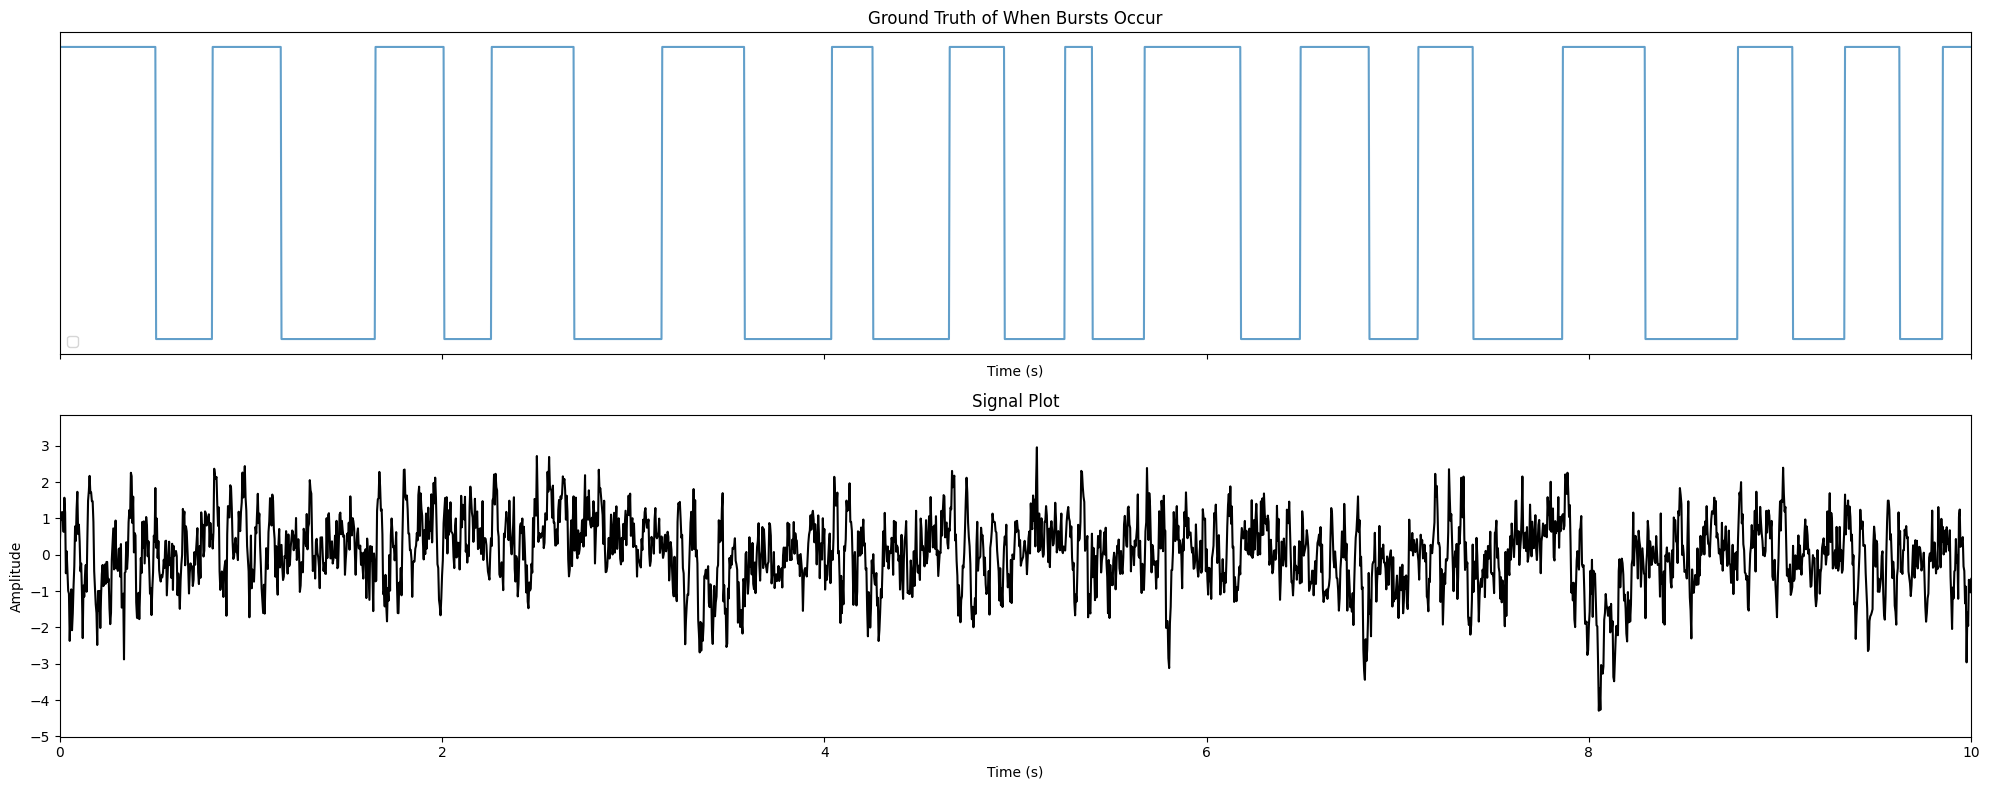

In [ ]:
signal = signal_sample[0,10,1].flatten()
label = states_sample[0,10,1].flatten()

visualize_training_data(label,signal)

In [ ]:
def visualize_training_data(label_sample, signal_sample, sampling_frequency=250, duration=30, time_window=(0, 10), category_labels=['noise', 'beta'], title="Ground Truth of When Bursts Occur"):
    """
    Visualizes training data with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 1D array of ground truth labels.
        signal_sample (np.ndarray): 1D array of signal data.
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
    """

    time_vec = np.linspace(0, duration, duration * sampling_frequency, endpoint=False)

    fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)


    # Visualizing burst labels as colors
    ax[0].plot(time_vec, label_sample, alpha=0.7)  # Adjust labels based on categories
    ax[0].set_xlabel("Time (s)")
    ax[0].set_yticks([])  # y-axis does not mean anything
    ax[0].set_title("Ground Truth of When Bursts Occur")
    ax[0].legend()

    # the period of blue: bursts
    ax[1].plot(time_vec, signal_sample, color="k")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Amplitude")
    ax[1].set_title("Signal Plot")

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

In [ ]:
signal_sample.shape

(10, 20, 5, 7500)

In [ ]:
#computing spectrum
from neurodsp.spectral import compute_spectrum
psds = []

for freq_id in range(signal_sample.shape[1]):
    f, psd = compute_spectrum(signal_sample[:, freq_id, :, :].flatten(), fs)
    psds.append(np.array(psd))

psds = np.array(psds)


In [ ]:
psds.shape

(20, 126)

In [ ]:
mean_psds = psds.mean(axis=0)  # average over samples for visualization

mean_psds.shape

(126,)

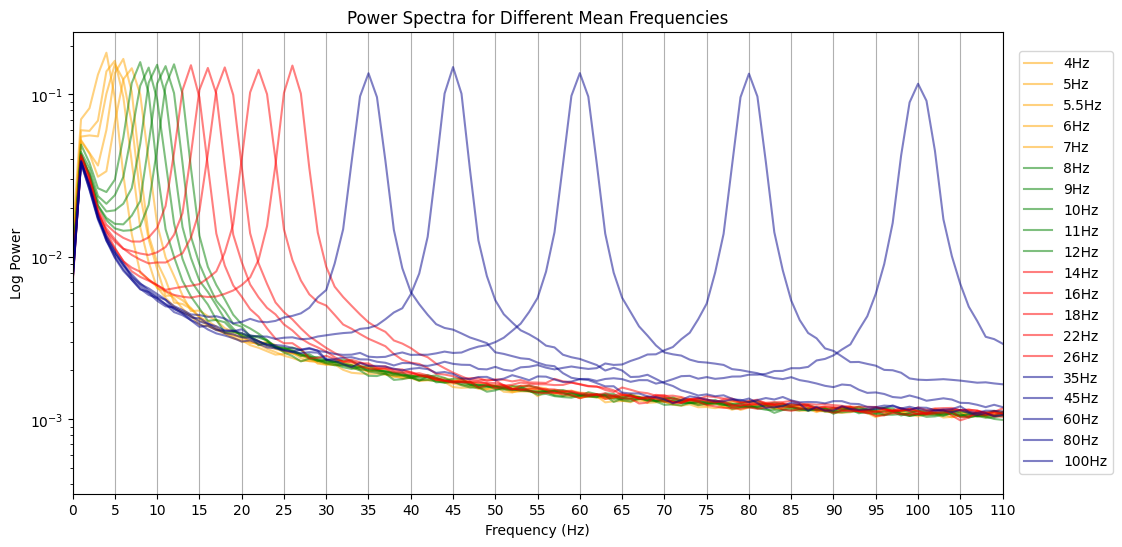

In [ ]:
# Define noise ratio labels
noise_labels = ["-8dB", "-4dB", "0dB", "4dB", "8dB"]
freq_labels = [f"{freq}Hz" for freq in mean_freqs_manual]

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size if needed

# Plot each power spectrum with a different color from the viridis colormap
colors = plt.cm.cividis(np.linspace(0.0, 0.9, psds.shape[0]))  # Get colors from YlGnBu_r

# Define custom color palette
custom_colors = ['orange', 'green', 'red', 'darkblue']  # Your four colors
colors = []
for color in custom_colors:
    colors.extend([color] * 5)  # Repeat each color 5 times

for i in range(psds.shape[0]):
    plt.semilogy(psds[i], color=colors[i], label=freq_labels[i], alpha=0.5)

# Customize the plot
plt.title("Power Spectra for Different Mean Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Power")

# **Change 1: Legend Position**
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')  # Move legend outside to the right

# **Change 2: X-axis Ticks**
plt.xticks(np.arange(0, 111, 5))  # Uniform ticks from 0 to 100 in 5er increments

plt.grid(True, which='both', axis='x')  # Enable grid lines for x-axis ticks
plt.xlim(0, 110)  # Set x-axis limits


plt.show()

## varying the distance of burst frequencies

In [ ]:
wave_shapes = ["sine", "sawtooth"]
snr = 0 #fixed to 0db


# Condition1: Base frequencies (Hz)
base_freqs = [10, 25, 35]

# Condition2: Secondary frequency variation settings
freq_step = 2         # Frequency increment (Hz)
num_variations = 6    # Total conditions (3 below and 3 above the base)
half_variations = num_variations // 2

# Generate frequency pairs: [base frequency, secondary frequency]
freq_pairs = []
for base in base_freqs:
    # Compute possible secondary frequencies around the base frequency
    secondary_freqs = np.arange(base - freq_step * half_variations,
                                base + freq_step * half_variations + 1,
                                freq_step)
    # Create pairs, excluding the base frequency itself
    pairs = [[base, f] for f in secondary_freqs if f != base]
    freq_pairs.append(pairs)

freq_pairs = np.array(freq_pairs)  # shape: (len(base_freqs), num_variations, 2)


###################################################################

# Initialize variables
states_sample = np.zeros((n_samples, len(wave_shapes), len(base_freqs), num_variations, len(time_vec)))
bursts_sample = np.zeros((n_samples, len(wave_shapes), len(base_freqs), num_variations, len(time_vec)))
noise_sample = np.zeros((n_samples, len(wave_shapes), len(base_freqs), num_variations, len(time_vec)))
signal_sample = np.zeros((n_samples, len(wave_shapes), len(base_freqs), num_variations, len(time_vec)))


# Loop over the number of samples.
for sample_id in range(n_samples):

    # Loop over wave conditions.
    for wave_shape_id, wave_shape in enumerate(wave_shapes):

        # Loop over frequency conditions
        for freq_id, freq in enumerate(base_freqs):

            # Loop over 2nd frequency conditions.
            for freq_pair_id, freq_pair in enumerate(freq_pairs[freq_id]):
                # Simulate a signal with sine bursts.
                states, bursts, noise, signal = simulate_bursty_signal(
                    time_vec, fs, freq_pair, burst_cycles, noise_duration,
                    burst_type= wave_shape, snr_db=snr, standardize=True
                )
                states_sample[sample_id, wave_shape_id, freq_id, freq_pair_id, :] = states
                bursts_sample[sample_id, wave_shape_id, freq_id, freq_pair_id, :] = bursts
                noise_sample[sample_id, wave_shape_id, freq_id, freq_pair_id, :] = noise
                signal_sample[sample_id, wave_shape_id, freq_id, freq_pair_id, :] = signal



print("Signal shape", signal_sample.shape, "[samples, wave shapes, base frequencies, 2nd frequency conditions, data points]")




Signal shape (10, 2, 3, 6, 15000) [samples, wave shapes, base frequencies, 2nd frequency conditions, data points]


In [ ]:
psds = []

for sample_id in range(signal_sample.shape[0]):
    for wave_shape_id in range(signal_sample.shape[1]):
        for freq_id in range(signal_sample.shape[2]):
            for freq_pair_id in range(signal_sample.shape[3]):
                f, psd = compute_spectrum(signal_sample[sample_id, wave_shape_id, freq_id, freq_pair_id, :], fs)
                psds.append(np.array(psd))

psds = np.array(psds).reshape(signal_sample.shape[0], signal_sample.shape[1], signal_sample.shape[2], signal_sample.shape[3], -1)


In [ ]:
mean_psds.shape


(2, 3, 11, 126)

/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_6933/1550603217.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_6933/1550603217.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[freq_pair_id].legend()


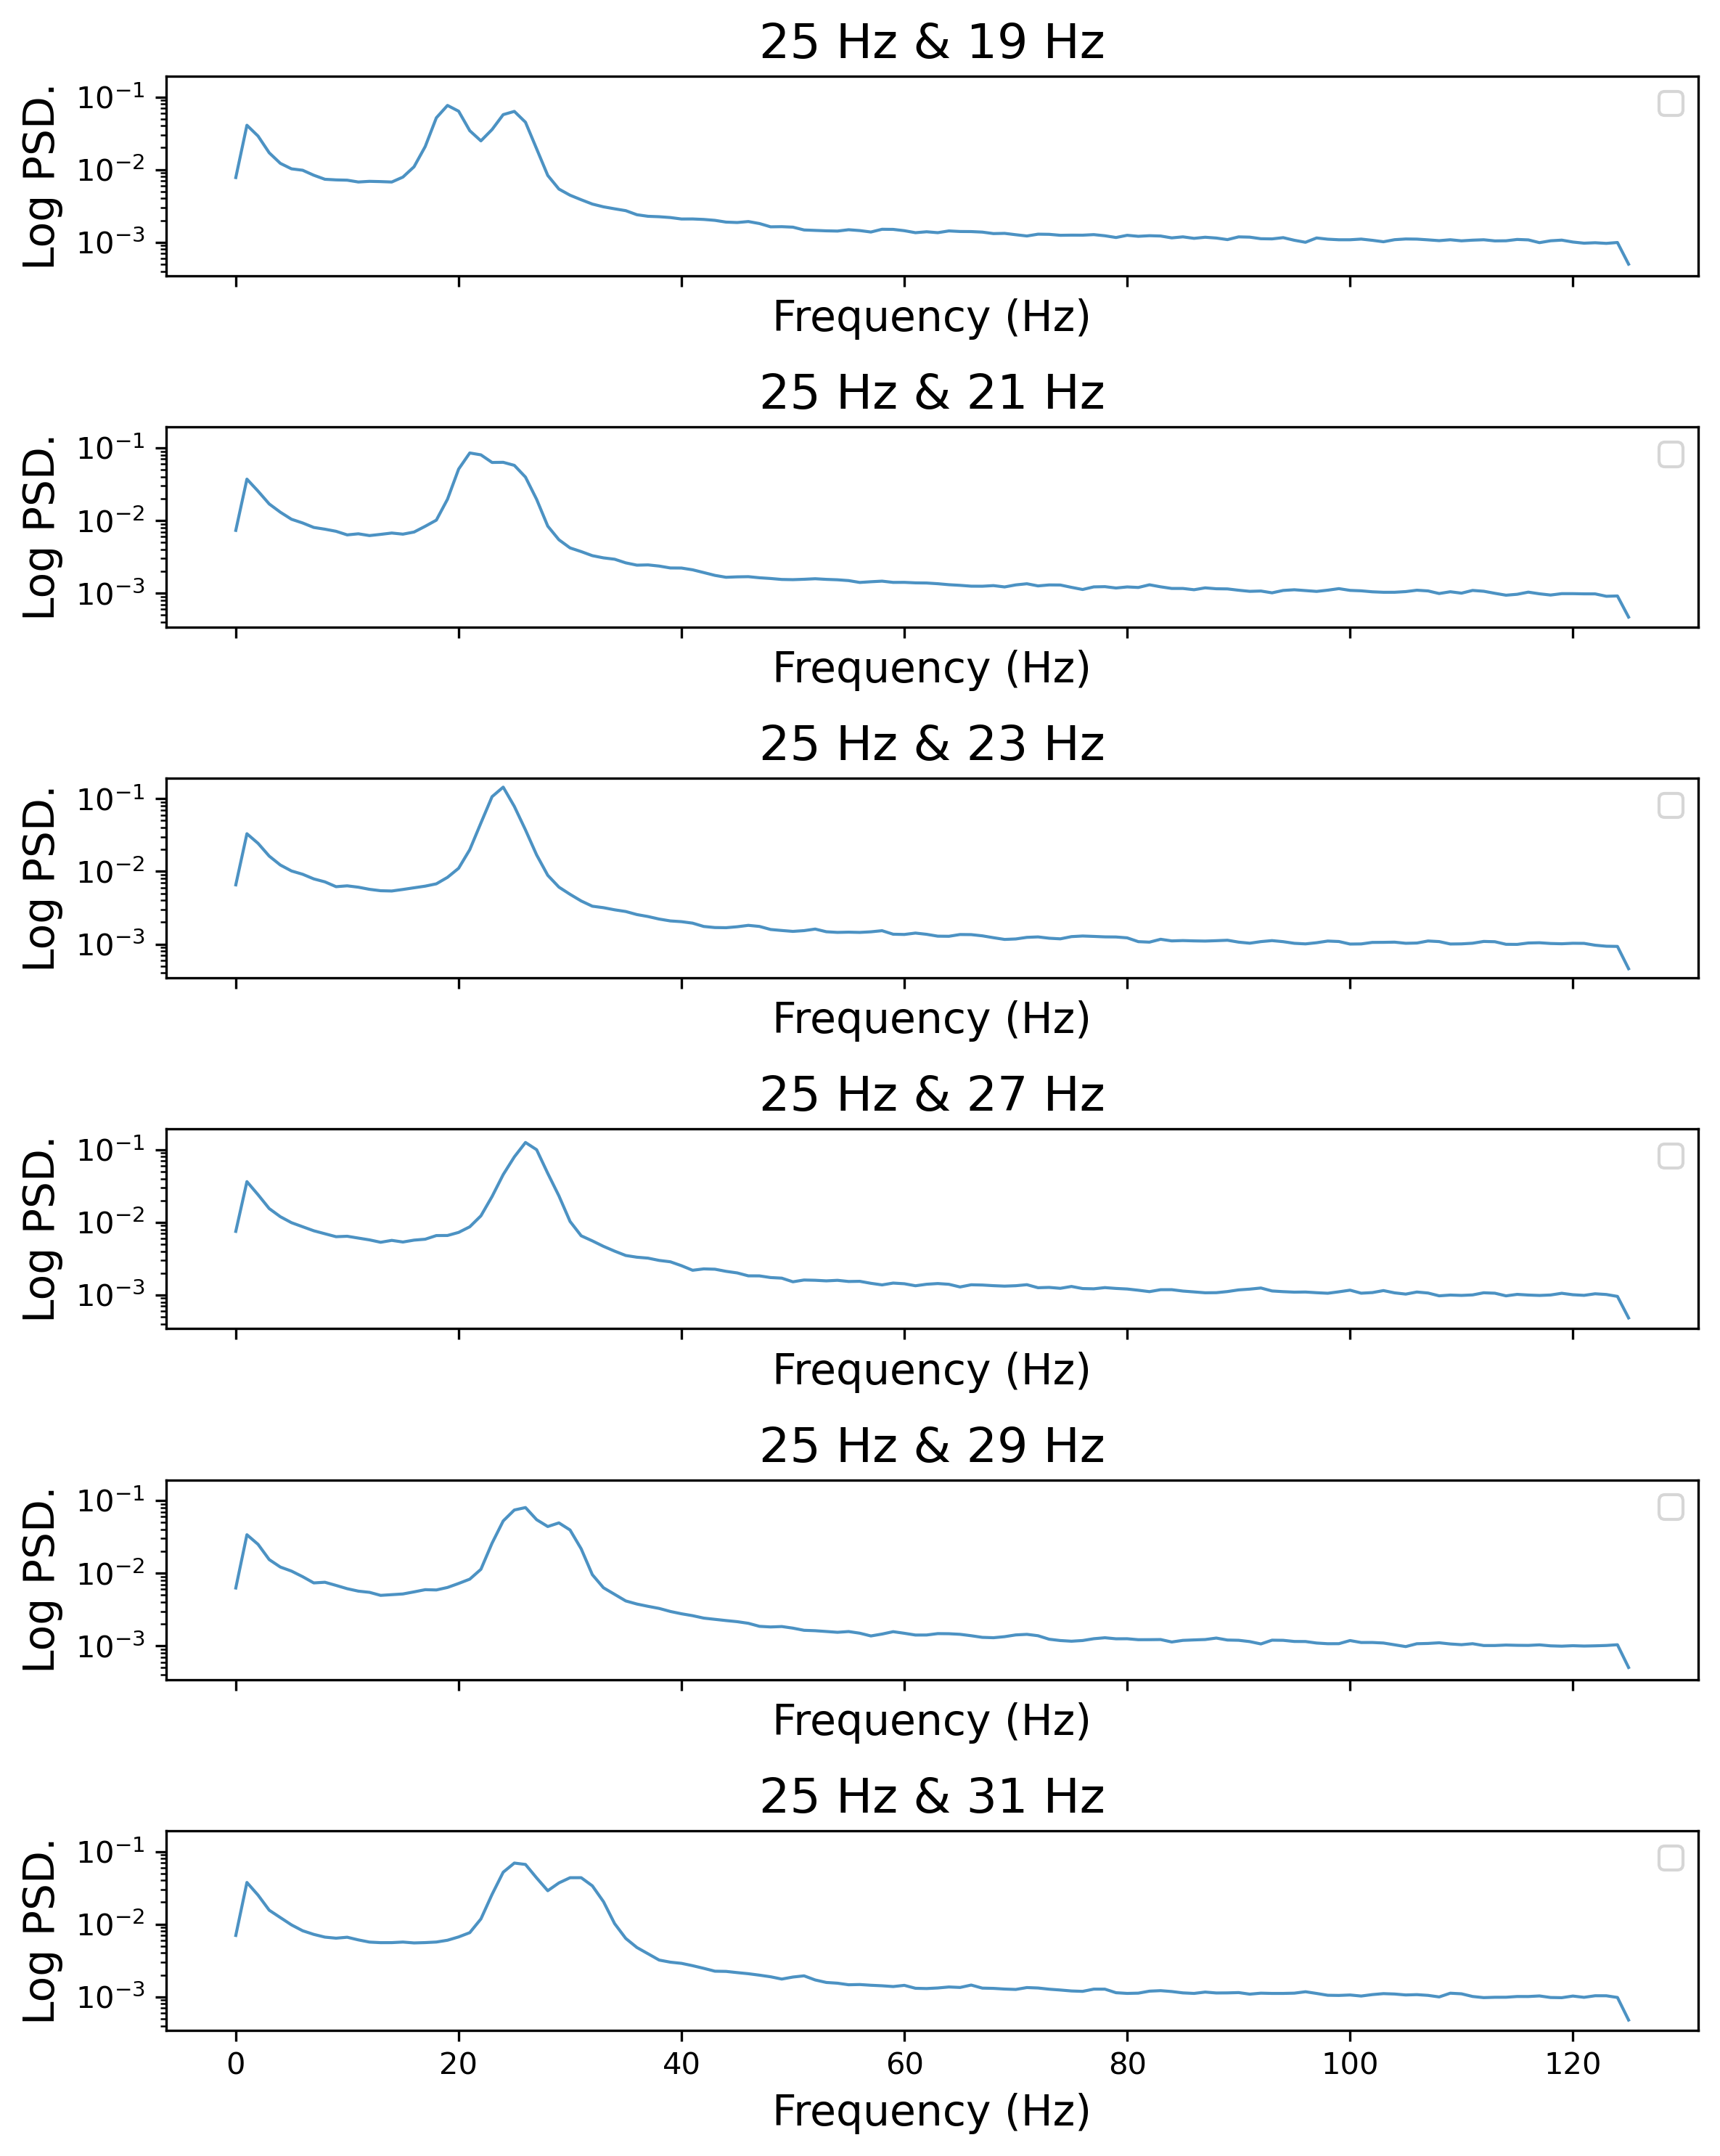

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Set high-resolution figures.
plt.rcParams["figure.dpi"] = 300

# Define colormap.
cmap = cm.get_cmap("viridis")

# Compute the mean PSDs (averaging over samples for visualization).
mean_psds = psds.mean(axis=0)

# Indices for selecting data.
wave_shape_id = 0
base_freq_id = 1

fig, ax = plt.subplots(mean_psds.shape[2], figsize=(8, 10), sharex=True, sharey=True)
for freq_pair_id in range(mean_psds.shape[2]):
    # Extract the PSD and frequency labels for the current condition.
    psd = mean_psds[wave_shape_id, base_freq_id, freq_pair_id]
    freqs_label = freq_pairs[base_freq_id, freq_pair_id]

    ax[freq_pair_id].plot(
        f,
        psd,
        linewidth=1,
        alpha=0.8
    )

    ax[freq_pair_id].set_yscale("log")
    ax[freq_pair_id].set_title(f"{freqs_label[0]} Hz & {freqs_label[1]} Hz", fontsize=16)
    ax[freq_pair_id].set_xlabel("Frequency (Hz)", fontsize=14)
    ax[freq_pair_id].set_ylabel("Log PSD.", fontsize=14)

    ax[freq_pair_id].legend()
plt.tight_layout()
plt.show()


/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_6933/3393937253.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_6933/3393937253.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[freq_pair_id].legend()


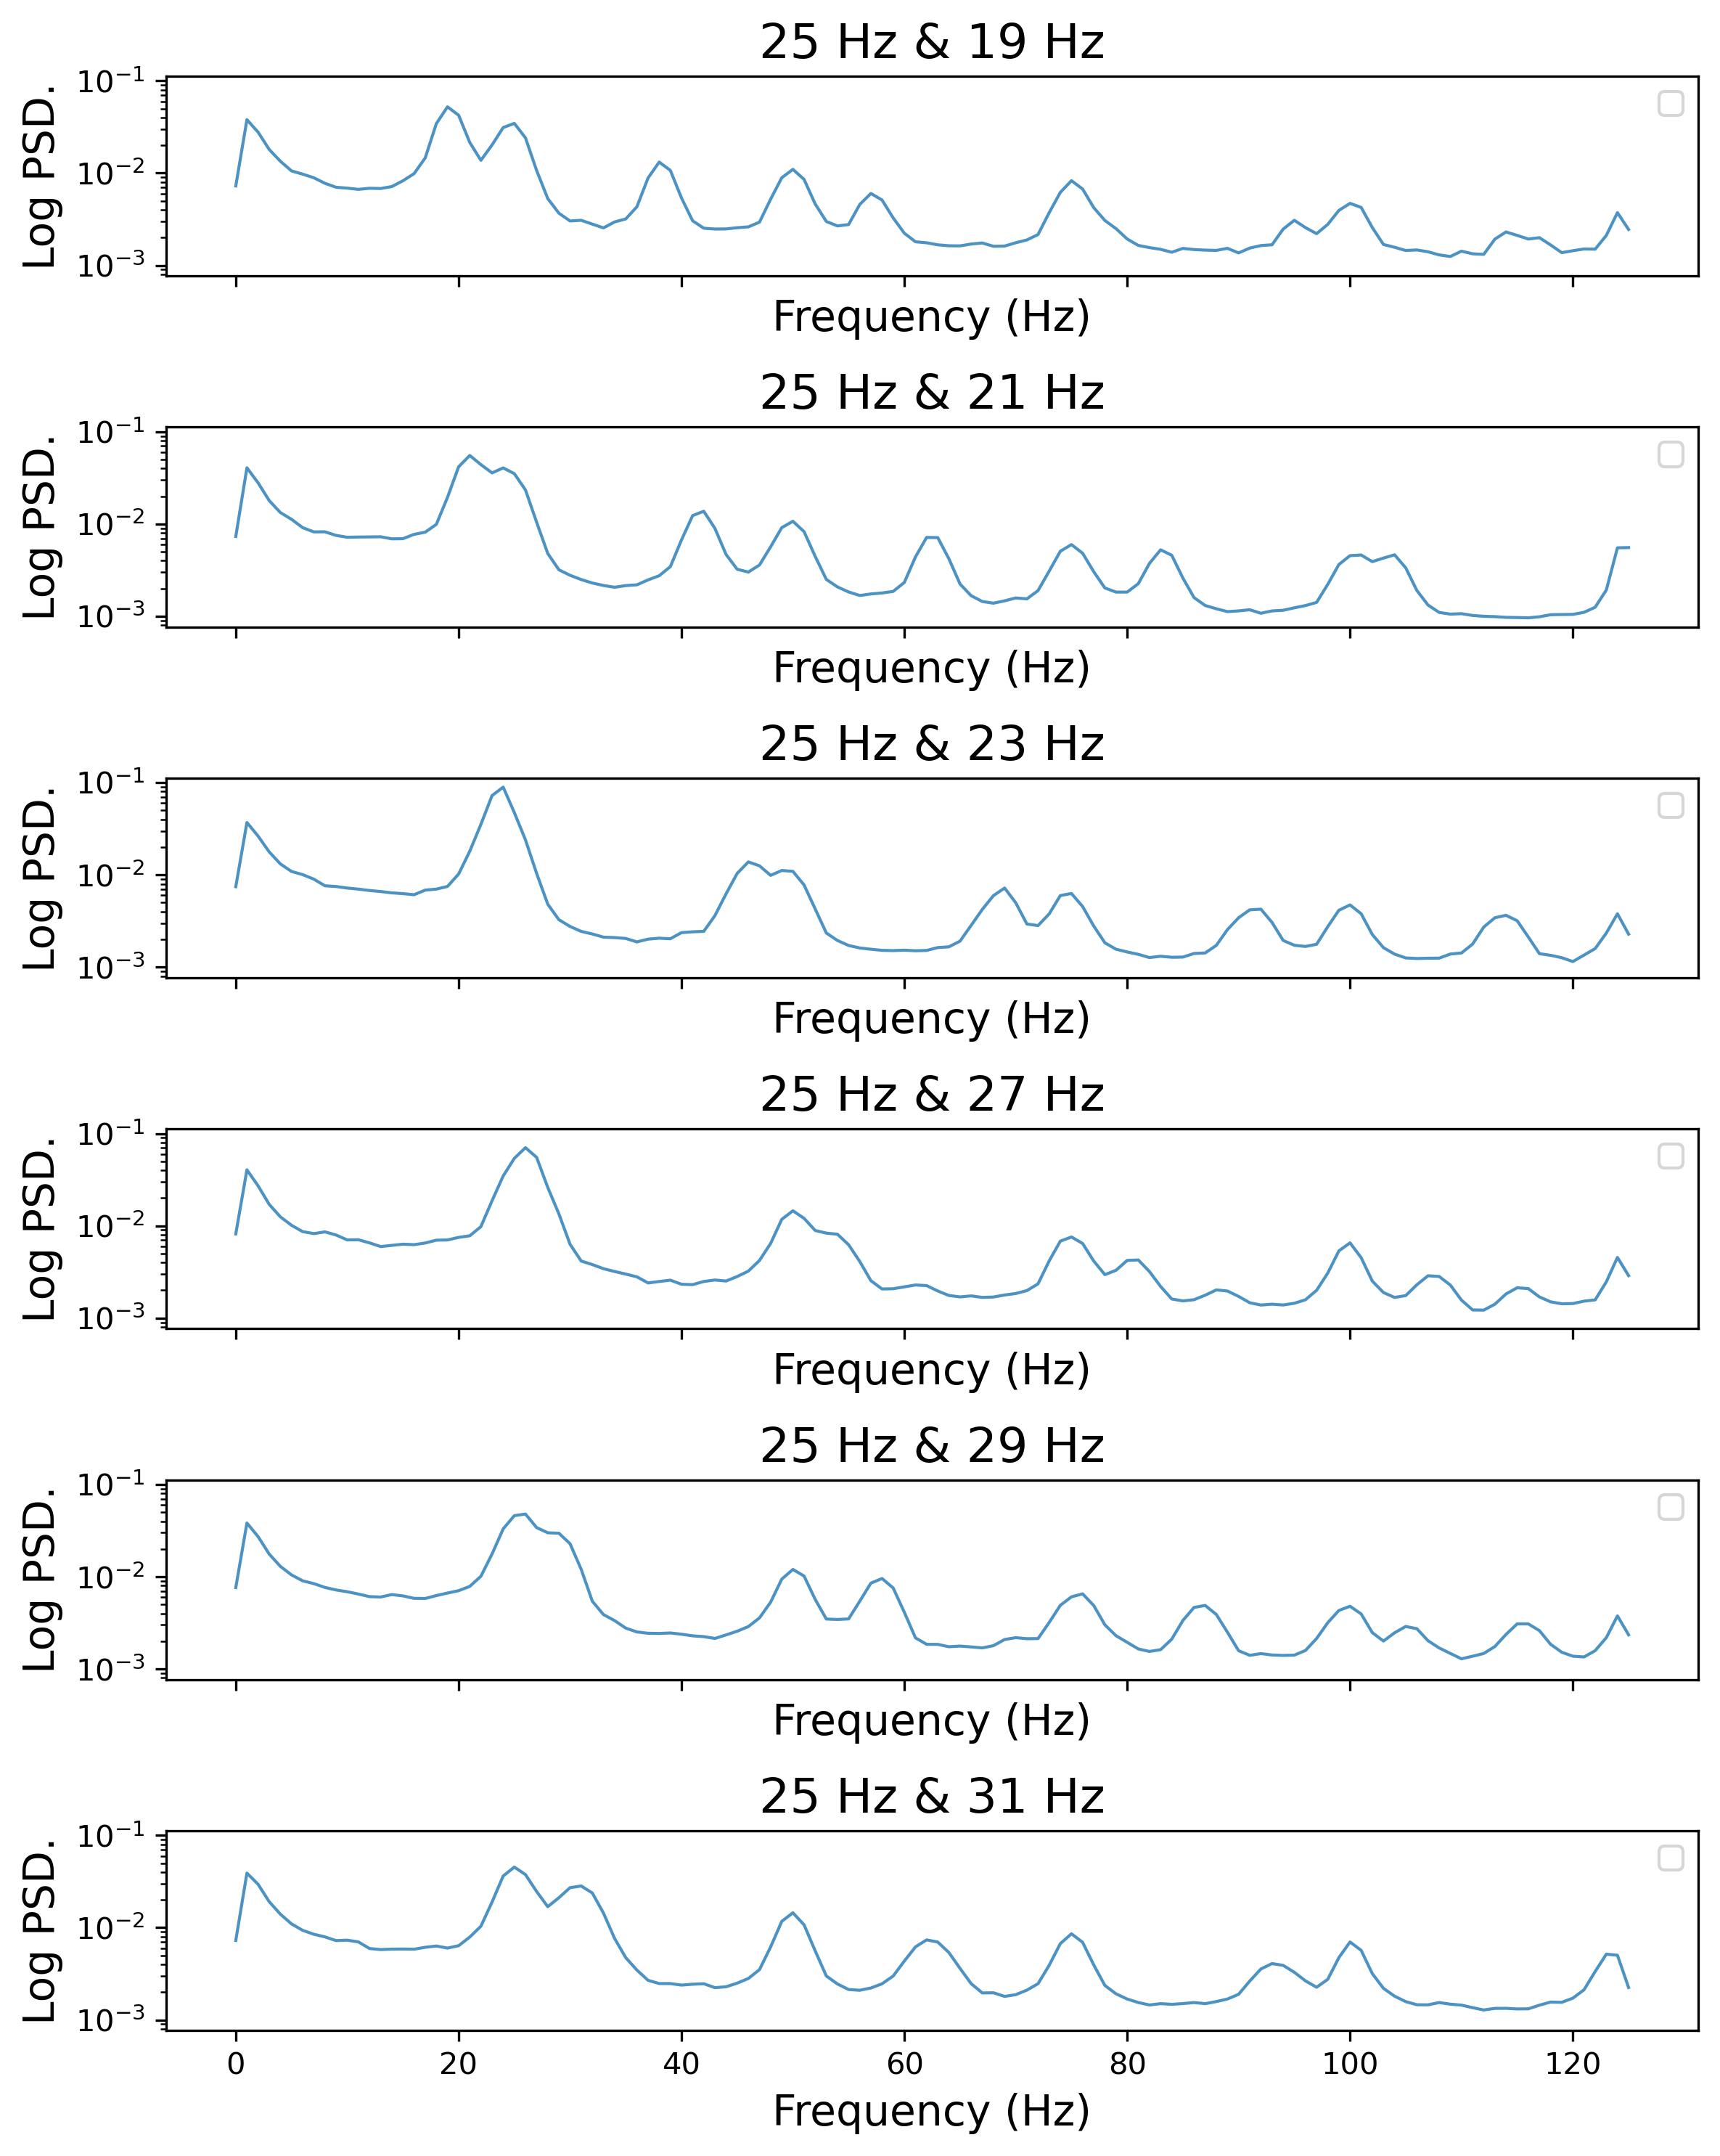

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Set high-resolution figures.
plt.rcParams["figure.dpi"] = 300

# Define colormap.
cmap = cm.get_cmap("viridis")

# Compute the mean PSDs (averaging over samples for visualization).
mean_psds = psds.mean(axis=0)

wave_shape_id = 1
base_freq_id = 1

fig, ax = plt.subplots(mean_psds.shape[2], figsize=(8, 10), sharex=True, sharey=True)
for freq_pair_id in range(mean_psds.shape[2]):
    # Extract the PSD and frequency labels for the current condition.
    psd = mean_psds[wave_shape_id, base_freq_id, freq_pair_id]
    freqs_label = freq_pairs[base_freq_id, freq_pair_id]

    ax[freq_pair_id].plot(
        f,
        psd,
        linewidth=1,
        alpha=0.8
    )

    ax[freq_pair_id].set_yscale("log")
    ax[freq_pair_id].set_title(f"{freqs_label[0]} Hz & {freqs_label[1]} Hz", fontsize=16)
    ax[freq_pair_id].set_xlabel("Frequency (Hz)", fontsize=14)
    ax[freq_pair_id].set_ylabel("Log PSD.", fontsize=14)

    ax[freq_pair_id].legend()
plt.tight_layout()
plt.show()


In [ ]:
import os

simulation_condition = "freq_dist"

os.makedirs("../data/simulations", exist_ok = True)

# Save all arrays in a single compressed .npz file
data_file = f"../data/simulations/{simulation_condition}_data.npz"
np.savez_compressed(data_file,
                    signal_sample=signal_sample,
                    states_sample=states_sample,
                    bursts_sample=bursts_sample,
                    noise_sample=noise_sample)

print(f"Data saved as {data_file}")


Data saved as ../data/simulations/freq_dist_data.npz
